## René Parlange, MSc
### 📚 Gravitational Lensing Course, PhD in Computer Science
#### 🎓 Instructors: Dr. Octavio Valenzuela (IA-UNAM), Dr. Juan Carlos Cuevas (UASLP) and Dr. Omar Cabrera (IA-UNAM)
####  🏛 Universidad Autónoma de San Luis Potosí (UASLP)

🔗 [GitHub Repository](https://github.com/parlange/gravitational-lensing)

# Python Applications
#### 📘 Introduction to Gravitational Lensing by Massimo Meneghetti
https://link.springer.com/book/10.1007/978-3-030-73582-1/

## 5.11.1 Numerical Solution of the Lens Equation

In most cases, the complexity of lens models prevents analytical solutions to the lens equation for a given source position. Instead, images must be found using numerical methods. This section discusses two approaches for solving the lens equation numerically for Singular Isothermal Ellipsoid (SIE) lenses.

## Multiple Images by an SIE Lens

Kormann et al. (1994) propose a method to solve the lens equation for SIE lenses
(see Sect.5.4.1). We begin with the two coordinates of the source, Equations 5.161 and 5.162,

\begin{align*}
y_1 &= x_1 - \alpha_1(x), \\
y_2 &= x_2 - \alpha_2(x).
\end{align*}

Multiplying Eq. 5.161 by cos ϕ and Eq. 5.162 by sin ϕ, we obtain Equations 5.163 and 5.164

\begin{equation}
y_1 \cos \phi = x_1 \cos \phi - \alpha_1(x) \cos \phi = x \cos^2 \phi - \alpha(x, \phi) \cos^2 \phi
\end{equation}

\begin{equation}
y_2 \sin \phi = x_2 \sin \phi - \alpha_2(x) \sin \phi = x \sin^2 \phi - \alpha(x, \phi) \sin^2 \phi
\end{equation}

We remind that

\begin{equation}
\alpha(x, \phi) = \tilde{\psi}(\phi)
\end{equation}

for the SIE lens (Eq. 5.165).

Equations 5.163 and 5.164 can be combined to compute the distance from the lens center as a function of $\phi$ (Eq. 5.166):

\begin{equation}
x(\phi) = y_1 \cos \phi + y_2 \sin \phi + \tilde{\psi}(\phi)
\end{equation}

By reinserting Eq. 5.166 into the lens equation, we finally obtain Eq. 5.167

\begin{equation}
F(\phi) = \left( y_1 + \sqrt{f} \frac{f}{\sin \phi} \right) \sinh^{-1} \left( \frac{\sqrt{f}}{f} \cos \phi \right) - \left( y_2 + \sqrt{f} \frac{f}{\cos \phi} \right) \arcsin\left( f \frac{\sin \phi}{\sqrt{f}} \right) \cos \phi = 0.
\end{equation}



Now the problem of finding the images of a source at position $(y_1, y_2)$ reduces to the problem of finding the zeros of $F(\phi)$. Once $\phi$ has been determined, it can be inserted in Eq. 5.166 above to obtain $x$.

The solutions cannot be found analytically: a root-finding algorithm such as Brent’s method must be employed.

The following code implements a class for the SIE lens. An instance of the class has five input parameters, namely the redshifts of the lens and the source $z_l$ and $z_s$, the velocity dispersion $\sigma_v$, the axis ratio $f$, and the position angle $pa$. The latter is the angle between the major axis of the lens and the axis $x_2$. An **astropy** cosmology object, **co**, must also be provided. The class includes methods to compute several quantities as a function of the coordinates on the lens plane, like the deflection angle, the convergence, the shear, and the lensing potential. It also includes functions to compute the critical line, the cut, and the caustic.


In [13]:
from astropy.constants import c, G
import numpy as np
from scipy.optimize import brentq
from astropy.cosmology import FlatLambdaCDM

class sie_lens(object):
    """
    class SIE
    """
    def __init__(self, co, zl=0.3, zs=2.0, sigmav=200, f=0.6, pa=45.0):
        """
        Initialize the SIE object.
        Dimensionless units are used. The scale angle is given by the
        SIS Einstein radius.
        """
        self.sigmav = sigmav  # velocity dispersion
        self.co = co  # cosmological model
        self.zl = zl  # lens redshift
        self.zs = zs  # source redshift
        self.f = f  # axis ratio
        self.pa = pa * np.pi / 180.0  # position angle
        # compute the angular diameter distances:
        self.dl = self.co.angular_diameter_distance(self.zl)
        self.ds = self.co.angular_diameter_distance(self.zs)
        self.dls = self.co.angular_diameter_distance_z1z2(self.zl, self.zs)
        # calculates the Einstein radius of the SIS lens
        # in arcsec
        self.theta0 = np.rad2deg((4.0 * np.pi * sigmav**2 / (c.to("km/s"))**2 * self.dls / self.ds).value) * 3600.0

    def delta(self, f, phi):
        return np.sqrt(np.cos(phi - self.pa)**2 + self.f**2 * np.sin(phi - self.pa)**2)

    def kappa(self, x, phi):
        """
        Convergence for the SIE lens at position (x, phi) in polar coordinates.
        """
        return (np.sqrt(self.f) / 2.0 / x / self.delta(self.f, phi))

    def gamma(self, x, phi):
        """
        Shear for the SIE lens at position (x, phi) in polar coordinates.
        """
        return (-self.kappa(x, phi) * np.cos(2.0 * phi - self.pa),
                -self.kappa(x, phi) * np.sin(2.0 * phi - self.pa))

    def mu(self, x, phi):
        """
        Magnification for the SIE lens at position (x, phi) in polar coordinates.
        """
        ga1, ga2 = self.gamma(x, phi)
        ga = np.sqrt(ga1 * ga1 + ga2 * ga2)
        return 1.0 / ((1.0 - self.kappa(x, phi) - ga) * (1.0 - self.kappa(x, phi) + ga))

    def psi_tilde(self, phi):
        """
        Angular part of the lensing potential at the polar angle phi
        """
        if (self.f < 1.0):
            fp = np.sqrt(1.0 - self.f**2)
            return np.sqrt(self.f) / fp * (
                np.sin(phi - self.pa) * np.arcsin(fp * np.sin(phi - self.pa)) +
                np.cos(phi - self.pa) * np.arcsinh(fp / self.f * np.cos(phi - self.pa)))
        else:
            return 1.0


    def psi(self, x, phi):
        """
        Lensing potential at polar coordinates x, phi
        """
        psi = x * self.psi_tilde(phi)
        return psi

    def alpha(self, phi):
        fp = np.sqrt(np.maximum(1.0 - self.f**2, 1e-10))  # Avoid division by zero by ensuring fp is never exactly 0

        # Compute the deflection angles with added safety checks for domain limits
        a1 = np.sqrt(self.f) / fp * np.arcsinh(fp / np.maximum(self.f, 1e-10) * np.cos(phi))  # Avoid divide by zero in self.f
        a2 = np.sqrt(self.f) / fp * np.arcsin(np.clip(fp * np.sin(phi), -1.0, 1.0))  # Clip values to valid arcsin domain

        return a1, a2

    # def alpha(self, phi):
    #     """
    #     Deflection angle as a function of the polar angle phi
    #     """
    #     fp = np.sqrt(1.0 - self.f**2)
    #     a1 = np.sqrt(self.f) / fp * np.arcsinh(fp / self.f * np.cos(phi))
    #     a2 = np.sqrt(self.f) / fp * np.arcsin(fp * np.sin(phi))
    #     return a1, a2

    def cut(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the cut.
        The arguments phi_min, phi_max, nphi define the range of
        polar angles used.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        y1_, y2_ = self.alpha(phi)
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return -y1, -y2

    def tan_caustic(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the tangential caustic.
        The arguments phi_min, phi_max, nphi define the range of
        polar angles used.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        a1, a2 = self.alpha(phi)
        y1_ = np.sqrt(self.f) / delta * np.cos(phi) - a1
        y2_ = np.sqrt(self.f) / delta * np.sin(phi) - a2
        y1 = y1_ * np.cos(self.pa) - y2_ * np.sin(self.pa)
        y2 = y1_ * np.sin(self.pa) + y2_ * np.cos(self.pa)
        return y1, y2

    def tan_cc(self, phi_min=0, phi_max=2.0 * np.pi, nphi=1000):
        """
        Coordinates of the points on the tangential critical line.
        The arguments phi_min, phi_max, nphi define the range of
        polar angles used.
        """
        phi = np.linspace(phi_min, phi_max, nphi)
        delta = np.sqrt(np.cos(phi)**2 + self.f**2 * np.sin(phi)**2)
        r = np.sqrt(self.f) / delta
        x1 = r * np.cos(phi + self.pa)
        x2 = r * np.sin(phi + self.pa)
        return x1, x2

    def x_ima(self, y1, y2, phi):
        """
        Distance of the image from the lens center
        """
        x = y1 * np.cos(phi) + y2 * np.sin(phi) + (self.psi_tilde(phi + self.pa))
        return x

    def phi_ima(self, y1, y2, checkplot=True, eps=0.001, nphi=100):
        """
        Solve the lens Equation for a given source position (y1, y2)
        """
        # source position in the frame where the lens major axis is
        # along the x_2 axis.
        y1_ = y1 * np.cos(self.pa) + y2 * np.sin(self.pa)
        y2_ = -y1 * np.sin(self.pa) + y2 * np.cos(self.pa)

        # This is Eq.\ref{eq:ffunct}
        def phi_func(phi):
            a1, a2 = self.alpha(phi)
            func = (y1_ + a1) * np.sin(phi) - (y2_ + a2) * np.cos(phi)
            return func

        # Evaluate phi_func and the sign of phi_func on an array of
        # polar angles
        U = np.linspace(0, 2.0 * np.pi + eps, nphi)
        c = phi_func(U)
        s = np.sign(c)
        phi = []
        xphi = []
        # loop over polar angles
        for i in range(len(U) - 1):
            # if two polar angles bracket a zero of phi_func
            # use Brent’s method to find exact solution
            if s[i] + s[i+1] == 0: # opposite signs
                u = brentq(phi_func, U[i], U[i+1])
                z = phi_func(u)
                if np.isnan(z) or abs(z) > 1e-3:
                    continue
                x = self.x_ima(y1_, y2_, u)
                # append solution to a list if it corresponds to radial
                # distances x > 0; discard otherwise (spurious solutions)
                if x > 0:
                    phi.append(u)
                    xphi.append(x)

        # convert lists to numpy arrays
        xphi = np.array(xphi)
        phi = np.array(phi)

        # returns radii and polar angles of the images. Add position angle
        # to go back to the rotated frame of the lens.
        return xphi, phi + self.pa

    def find_images(self, ys1_, ys2_, xmin=-2, xmax=2, npix=2048):
        ys1 = ys1_ * np.cos(self.pa) + ys2_ * np.sin(self.pa)
        ys2 = - ys1_ * np.sin(self.pa) + ys2_ * np.cos(self.pa)
        # create a mesh in the search region:
        x = np.linspace(xmin, xmax, npix)
        grid_pixel = x[1] - x[0]
        x1, x2 = np.meshgrid(x, x)

        # compute deflections at each grid point
        phi = np.arctan2(x2, x1)
        x = np.sqrt(x1**2 + x2**2)
        a1, a2 = self.alpha(phi)

        # ray-trace the deflector grid onto the source plane
        y1 = x1 - a1
        y2 = x2 - a2

        # convert to pixel units
        xray = y1 / grid_pixel + (len(x) - 1) / 2.0
        yray = y2 / grid_pixel + (len(x) - 1) / 2.0
        y1s = ys1 / grid_pixel + (len(x) - 1) / 2.0
        y2s = ys2 / grid_pixel + (len(x) - 1) / 2.0

        # shift the maps by one pixel
        xray1 = np.roll(xray, 1, axis=1)
        xray2 = np.roll(xray1, 1, axis=0)
        xray3 = np.roll(xray2, -1, axis=1)
        yray1 = np.roll(yray, 1, axis=1)
        yray2 = np.roll(yray1, 1, axis=0)
        yray3 = np.roll(yray2, -1, axis=1)

        # for each pixel on the lens plane, build two triangles.
        # Using ray-tracing, these are mapped onto the source plane
        # into the other two triangles. Compute the distances of the
        # vertices of the triangles on the source plane from the source
        # and check using cross-products if the source is inside one of
        # the two triangles

        x1 = y1s - xray
        y1 = y2s - yray

        x2 = y1s - xray1
        y2 = y2s - yray1

        x3 = y1s - xray2
        y3 = y2s - yray2

        x4 = y1s - xray3
        y4 = y2s - yray3

        prod12 = x1 * y2 - x2 * y1
        prod23 = x2 * y3 - x3 * y2
        prod31 = x3 * y1 - x1 * y3
        prod13 = -prod31
        prod34 = x3 * y4 - x4 * y3
        prod41 = x4 * y1 - x1 * y4

        image = np.zeros(xray.shape)
        image[((np.sign(prod12) == np.sign(prod23)) & (np.sign(prod23) == np.sign(prod31)))] = 1
        image[((np.sign(prod13) == np.sign(prod34)) & (np.sign(prod34) == np.sign(prod41)))] = 2

        # first kind of images (first triangle)
        images1 = np.argwhere(image == 1)
        xi_images_ = images1[:, 1]
        yi_images_ = images1[:, 0]
        xi_images = xi_images_[(xi_images_ > 0) & (yi_images_ > 0)]
        yi_images = yi_images_[(xi_images_ > 0) & (yi_images_ > 0)]

        # compute the weights
        w = np.array([1. / np.sqrt(x1[xi_images, yi_images] ** 2 + y1[xi_images, yi_images] ** 2),
                      1. / np.sqrt(x2[xi_images, yi_images] ** 2 + y2[xi_images, yi_images] ** 2),
                      1. / np.sqrt(x3[xi_images, yi_images] ** 2 + yray3[xi_images, yi_images] ** 2)])
        xif1, yif1 = self.refineImagePositions(xi_images, yi_images, w, 1)

        # second kind of images (second triangle)
        images1 = np.argwhere(image == 2)
        xi_images_ = images1[:, 1]
        yi_images_ = images1[:, 0]
        xi_images = xi_images_[(xi_images_ > 0) & (yi_images_ > 0)]
        yi_images = yi_images_[(xi_images_ > 0) & (yi_images_ > 0)]

        # compute the weights
        w = np.array([1. / np.sqrt(x1[xi_images, yi_images] ** 2 + y1[xi_images, yi_images] ** 2),
                      1. / np.sqrt(x3[xi_images, yi_images] ** 2 + y3[xi_images, yi_images] ** 2),
                      1. / np.sqrt(x4[xi_images, yi_images] ** 2 + y4[xi_images, yi_images] ** 2)])
        xif2, yif2 = self.refineImagePositions(xi_images, yi_images, w, 2)

        # compute the weights
        xi = np.concatenate([xif1, xif2])
        yi = np.concatenate([yif1, yif2])

        xi = (xi - 1 - (len(x)-1) / 2.0) * grid_pixel
        yi = (yi - 1 - (len(x)-1) / 2.0) * grid_pixel

        xi_ = xi * np.cos(self.pa) - yi * np.sin(self.pa)
        yi_ = xi * np.sin(self.pa) + yi * np.cos(self.pa)
        return (xi_, yi_)


    def refineImagePositions(self, x, y, w, typ):
        """
        Image positions are calculated as the weighted mean of the
        positions of the triangle vertices. The weights are the distances
        between the vertices mapped onto the source plane and the source
        position.
        """
        if typ == 2:
            xp = np.array([x, x + 1, x + 1])
            yp = np.array([y, y, y + 1])
        else:
            xp = np.array([x, x + 1, x])
            yp = np.array([y, y + 1, y + 1])
        xi = np.zeros(x.size)
        yi = np.zeros(y.size)
        for i in range(x.size):
            xi[i] = (xp[:, i] / w[:, i]).sum() / (1. / w[:, i]).sum()
            yi[i] = (yp[:, i] / w[:, i]).sum() / (1. / w[:, i]).sum()
        return xi, yi


The method to solve Eq. 5.167 is implemented in the function **phi\_ima** below. First, we evaluate the function $F$ on an array of polar angles $\phi$. Then, we loop over the elements of the array, checking whether $F$ changes sign between two consecutive polar angles. When this happens, a zero of the function $F$ is bracketed by these polar angles, and it is determined by using Brent's method. This is implemented in the **scipy.optimize** module, for example.


The function phi_ima returns the coordinates of the multiple images in polar coordinates $(x_i, \phi_i)$.

In the following example, we use the functions above to find the images of a source at position $(y_1 = 0.2, y_2 = 0.2)$:



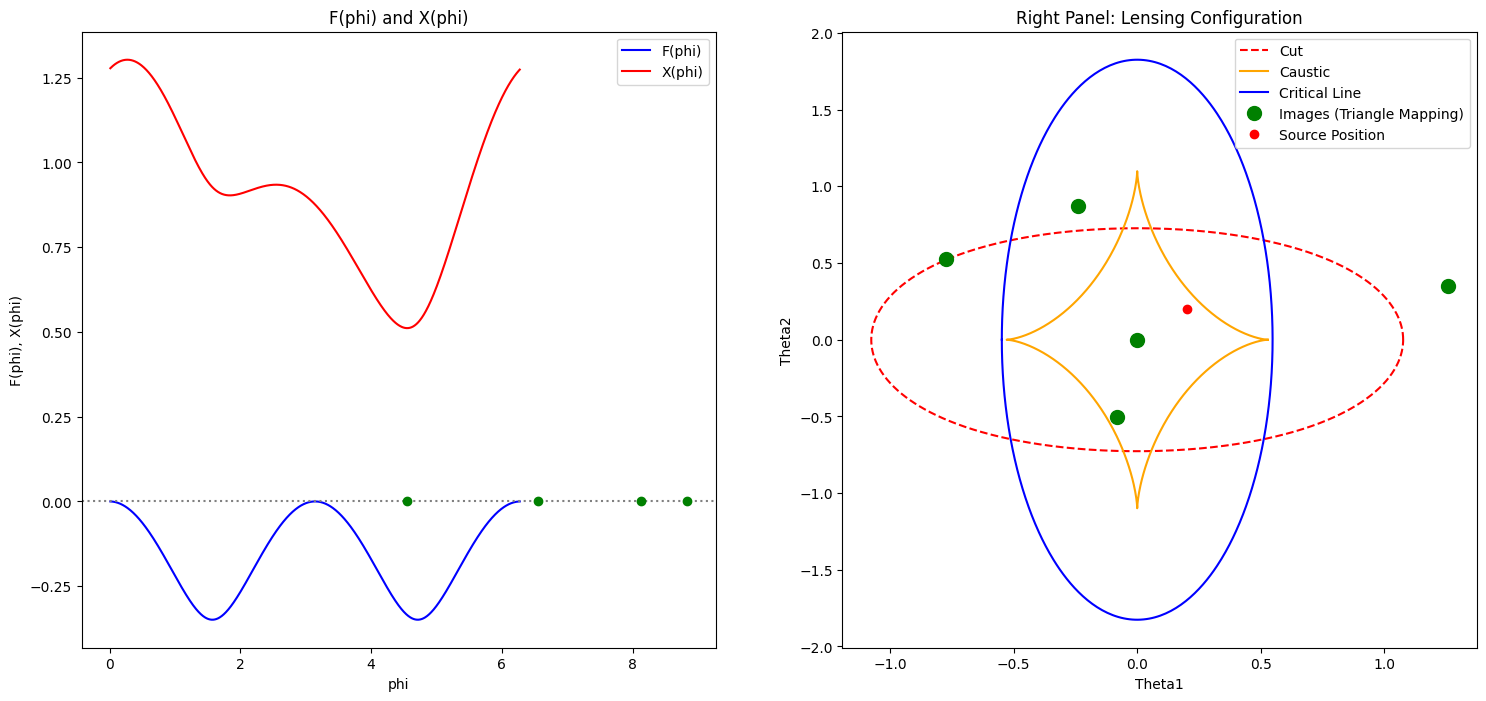

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Define the cosmology object and initialize the SIE lens instance
co = FlatLambdaCDM(Om0=0.3, H0=70.0)
sie = sie_lens(co, sigmav=200, f=0.3, pa=180)
#sie = sie_lens(co, zl=0.3, zs=2.0, sigmav=200, f=0.3, pa=0.0)

# Define the source coordinates
y1, y2 = 0.2, 0.2

# Find images using the find_images method for given source coordinates
xi, yi = sie.find_images(y1, y2)

# Compute polar coordinates of the images
x, phi = sie.phi_ima(y1, y2)

# Set up a figure for plotting
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Left Panel: Plot F(phi) and X(phi)
phi_values = np.linspace(0.01, 2 * np.pi - 0.01, 1000)
F_values = sie.psi_tilde(phi_values) - np.max(sie.psi_tilde(phi_values))
ax[0].plot(phi_values, F_values, color='blue', label='F(phi)')
ax[0].axhline(0, color='gray', linestyle='dotted')  # y=0 line

# Compute X(phi) values
X_values = sie.x_ima(y1, y2, phi_values)

# Plot X(phi)
ax[0].plot(phi_values, X_values, color='red', label='X(phi)')

# Highlight correct image positions on the F(phi) plot as intersections
for i in range(len(x)):
    ax[0].plot(phi[i], 0, 'go')  # Marking all image positions as green dots on y=0

ax[0].set_title('F(phi) and X(phi)')
ax[0].set_xlabel('phi')
ax[0].set_ylabel('F(phi), X(phi)')
ax[0].legend()

# Right Panel: Plot critical lines, caustics, and images
# Critical lines and caustics
y1_cut, y2_cut = sie.cut()
y1_cau, y2_cau = sie.tan_caustic()
x1_cc, x2_cc = sie.tan_cc()
ax[1].plot(y1_cut, y2_cut, 'r--', label='Cut')
ax[1].plot(y1_cau, y2_cau, 'orange', label='Caustic')
ax[1].plot(x1_cc, x2_cc, 'b-', label='Critical Line')

# Images (triangle mapping) and source position
ax[1].plot(xi, yi, 'go', label='Images (Triangle Mapping)', markersize=10)
ax[1].plot(y1, y2, 'ro', label='Source Position')

ax[1].set_title('Right Panel: Lensing Configuration')
ax[1].set_xlabel('Theta1')
ax[1].set_ylabel('Theta2')
ax[1].legend()

plt.show()


The results are shown in Fig. 5.27. The functions $F(\phi)$ and $x(\phi)$ are represented by the blue and orange lines in the left panel, respectively. The zeros of $F(\phi)$, found using the method outlined above, are marked with green dots. In the right panel, the solid and dashed lines depict the caustic and cut of the lens, respectively. The solid blue line represents the lens critical line. The source’s position is indicated by the orange dot, while the images are displayed in green.


## 5.11.2 Triangle Mapping

The triangle mapping method (see e.g. Bartelmann 2003, Schneider et al. 1992) is
more generic and can be used with any lens model, including non-analytic mass
distributions.

The method is grid-based. Consider a regular grid covering the lens plane, with cell corners at positions $x_{ij}$, where $i, j \in [0, N)$. We could find the images of a given source by checking if that source falls into one or more of the grid cells when these are mapped onto the source plane via ray-tracing (see, e.g., Sect. 3.7.1).


Fig. 5.27 Solution of the lens equation for an SIE lens. Left panel: the blue and orange lines show the functions $F(\phi)$ and $x(\phi)$. The green dots indicate the zeros of $F(\phi)$. The lens caustic and cut are shown by the solid and dashed lines in the right panel. The solid blue line represents the lens critical line. The positions of the source and its multiple images computed using the method in Sect. 5.11.1 are marked with orange and green points, respectively. The yellow crosses overlapped with the green dots show the image positions determined using the triangle mapping method discussed in Sect. 5.11.2.


This problem can be solved by splitting each grid cell on the lens plane into two
triangles. When mapped onto the source plane, these remain triangles. If one or
more of these triangles contain the source, then the source can be associated with
the image positions at the center of the corresponding triangles on the lens plane.

To check whether a source point is inside or outside a triangle, the following method can be employed. Let $\vec{d_k}$ be the vectors connecting the triangle’s vertices to the source point, with $k \in [1..3]$. It can be shown that the source point falls within the triangle if the three vector products

 $\vec{d_1} \times \vec{d_2}$, $\vec{d_1} \times \vec{d_3}$, and $\vec{d_2} \times \vec{d_3}$

 are all positive. The method is implemented in the Python function find_images included in the sie_lens class.


This method works well if the image separation is larger than the size of grid
cells on the image plane. Therefore, it might fail to find images of sources just inside
the caustics. Indeed, such sources have pairs or triplets of close images forming on
the opposite sides of the critical lines. To solve this problem, one can implement
adaptive meshes to refine the number of grid cells near these regions.

The function find_images can be included in the class SIE and used to recompute
the multiple images of the source in the example discussed in Sect. 5.11.1.
The resulting image positions are shown by the yellow crosses overlapped with the
green dots in Fig. 5.27 and are identical to those computedwith the previous method.

## 5.11.3 SIS Lens in an External Shear

How do the properties of a SIS lens change when we embed it in an external shear?
In this example, we answer this question.

We begin by implementing a class for the external shear lens model. The class
will contain methods to compute several quantities, namely the lensing potential,
the deflection angle, and the shear. Eqs. 5.129 and 5.128 give the lensing potential
and the components of a constant external shear. By construction, the convergence
is zero. We obtain the deflection angle components by differentiating the lensing
potential,

\begin{equation}
\alpha_1(x, \varphi) = \cos \varphi \frac{\partial \gamma (x, \varphi)}{\partial x} - \frac{\sin \varphi}{x} \frac{\partial \gamma (x, \varphi)}{\partial \varphi}
\end{equation}

\begin{equation}
\alpha_2(x, \varphi) = \sin \varphi \frac{\partial \gamma (x, \varphi)}{\partial x} + \frac{\cos \varphi}{x} \frac{\partial \gamma (x, \varphi)}{\partial \varphi}
\end{equation}


which gives

\begin{equation}
\alpha_1(x, \varphi) = \gamma x \cos(2\varphi_{\gamma} - \varphi)
\end{equation}

\begin{equation}
\alpha_2(x, \varphi) = \gamma x \sin(2\varphi_{\gamma} - \varphi)
\end{equation}


The class is implemented as follows:

In [3]:
class ext_shear(object):
    def __init__(self, g, phi_g):
        """
        Initialize an external shear using
        the amplitude g and the angle phi_g (in degrees)
        """
        self.g = g
        self.phi_g = np.deg2rad(phi_g)

    def psi(self, x, phi):
        """
        Returns the lensing potential at polar
        coordinates x, phi
        """
        return 0.5 * self.g * x**2 * np.cos(2 * (phi - self.phi_g))

    def alpha(self, x, phi):
        """
        Returns the components of the deflection
        angle at polar coordinates x, phi
        """
        a1 = self.g * x * np.cos(2 * self.phi_g - phi)
        a2 = self.g * x * np.sin(2 * self.phi_g - phi)
        return a1, a2

    def gamma(self):
        """
        Returns the components of the shear
        at polar coordinates x, phi
        """
        g1 = self.g * np.cos(2 * self.phi_g)
        g2 = self.g * np.sin(2 * self.phi_g)
        return g1, g2

We assume an external shear of amplitude $\gamma = 0.1$ and direction $\varphi_{\gamma} = 45^\circ$ relative to the $x_2$ axis.

In [4]:
eg=ext_shear(g=0.1,phi_g=45.0)

We construct an instance of a SIS lens by using the sie_lens class from the
previous example, setting f = 1:

In [5]:
# define a SIS lens with sigmav=200 km/s (i.e. a SIE with f=1.0, pa=0.0)
sigmav=200.0
f=1.0
pa=0.0
# assume a flat LCDM cosmology with Om0=0.3
co = FlatLambdaCDM(Om0=0.3,H0=70.0)
sie=sie_lens(co,sigmav=sigmav,f=f,pa=pa)

To embed the SIS in the external shear, we use the superposition principle. The
total potential is the sum of the potentials of the SIS and external shear.We define a
regular grid on the lens plane and compute the polar coordinates:

In [6]:
# define a grid on the lens plane
fov=3.0
x_ = np.linspace(-fov/2.,fov/2.,1000)
x1,x2 = np.meshgrid(x_,x_)
# compute phases and distances from the center of the SIS,
# assumed to be at the center of the grid, in (0,0)
phi=np.arctan2(x2,x1)
x=np.sqrt(x1*x1+x2*x2)

The total convergence at any position on the lens plane is simply the convergence of
the SIS:

In [7]:
# SIS kappa map:
kappa_SIS = sie.kappa(x,phi)

We show this map in panel A of Fig. 5.28. Instead, we obtain the total potential as
follows:

In [8]:
# SIS potential map:
psi_SIS=sie.psi(x,phi)
# external shear potential map:
psi_eg=eg.psi(x,phi)
# total lensing potential
psi_tot=psi_SIS+psi_eg

In panel B of Fig. 5.28, we show the total lensing potential of the SIS embedded
in the external shear. The solid contours show levels of constant potential. These
contours are elongated in the direction of the external shear. Thus, the lensing
potential is no longer axially symmetric. On the contrary, it is similar to that of
an elliptical lens, although the contours are not elliptical and their elongation is
not constant. For comparison, we also show the contour levels of the SIS potential
without external shear using dotted lines.

To derive the critical lines, we compute the map of the tangential eigenvalue of
the lensing Jacobian. For this purpose, we need to calculate the components of the shear first:

In [9]:
# SIS shear components:
g1_SIS,g2_SIS=sie.gamma(x,phi)
# external shear components:
g1_eg, g2_eg = eg.gamma()
# total shear components
g1_tot=g1_SIS+g1_eg
g2_tot=g2_SIS+g2_eg

We obtain the tangential eigenvalue map as follows:

In [10]:
#tangential eigenvalue:
lambdat_tot = 1.0 - kappa_SIS - np.sqrt(g1_tot**2+g2_tot**2)

The tangential critical line is the level-zero contour of this map. We show it in
panel C of Fig. 5.28 (solid red line). Since the lensing potential is no longer axially
symmetric, the lens critical line is not circular as for the SIS lens (blue dashed line).
Similar to the potential contours, it is elongated in the direction of φγ . Mapping
the critical points onto the source plane, we obtain the lens caustic, which is not a
single point, as for the SIS. It has an astroid-like shape with cusps and folds, similar
to elliptical lenses. Since the caustic is not point-like, the SIS lens embedded in the
external shear produces four images if the source is within the caustic.

[1.66667791e-11 1.66657799e-11 1.66627823e-11 1.66577863e-11
 1.66507919e-11 1.66419101e-11 1.66312519e-11 1.66185954e-11
 1.66033853e-11 1.65868430e-11]
[ 0.00000000e+00 -4.33680869e-18 -3.29597460e-17 -1.11022302e-16
 -2.67147415e-16 -5.13478149e-16 -8.88178420e-16 -1.40859546e-15
 -2.10942375e-15 -3.01147995e-15]


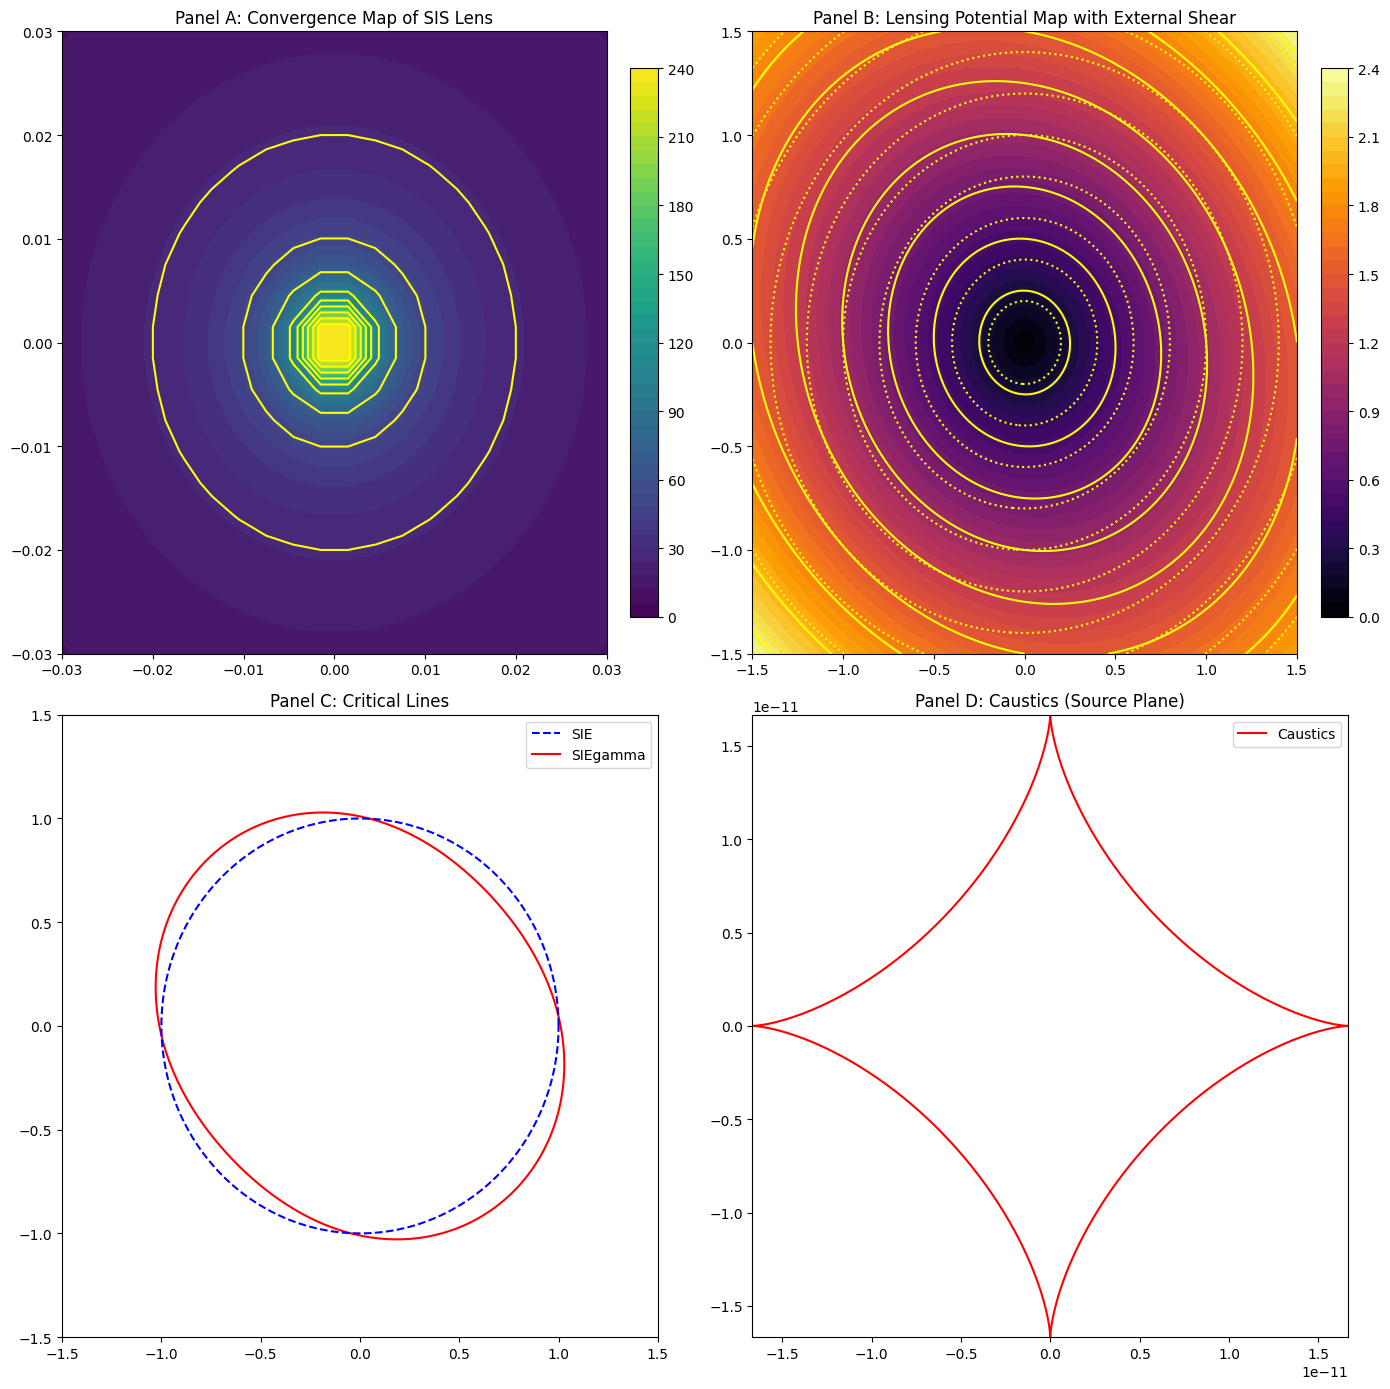

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Define the external shear and SIE lens with the provided parameters
eg = ext_shear(g=0.1, phi_g=45.0)  # External shear
co = FlatLambdaCDM(Om0=0.3, H0=70.0)  # Cosmology
sie = sie_lens(co, sigmav=200.0, f=1.0, pa=0.0)  # SIE lens

# Grid for lensing computations
fov = 3.0  # Field of view
x = np.linspace(-fov/2., fov/2., 1000)
x1, x2 = np.meshgrid(x, x)
r = np.sqrt(x1**2 + x2**2)
phi = np.arctan2(x2, x1)

# Compute the SIS lens' convergence (kappa)
kappa_sis = sie.kappa(r, phi)

# Compute the potential for SIS and external shear
psi_sis = sie.psi(r, phi)
psi_eg = eg.psi(r, phi)
psi_total = psi_sis + psi_eg

# Shear components and tangential eigenvalue for critical lines
g1_sis, g2_sis = sie.gamma(r, phi)
g1_eg, g2_eg = eg.gamma()
g1_total = g1_sis + g1_eg
g2_total = g2_sis + g2_eg

lambdat_tot = 1 - kappa_sis - np.sqrt(np.maximum(g1_total**2 + g2_total**2, 0))
critical_lines = np.abs(lambdat_tot) < 0.001  # Numerical threshold for critical lines

# Compute caustics
y1_cau, y2_cau = sie.tan_caustic()

# Plotting the four panels
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Panel A: Convergence map
ax = axs[0, 0]
convergence_contours = ax.contourf(x, x, kappa_sis, cmap='viridis', levels=40)
ax.contour(x, x, kappa_sis, levels=10, colors='yellow')
fig.colorbar(convergence_contours, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlim([-fov/100, fov/100])
ax.set_ylim([-fov/100, fov/100])
ax.set_title('Panel A: Convergence Map of SIS Lens')

# Panel B: Lensing potential map
ax = axs[0, 1]
potential_contours = ax.contourf(x, x, psi_total, cmap='inferno', levels=40)
ax.contour(x, x, psi_sis, colors='yellow', levels=10, linestyles='dotted')
ax.contour(x, x, psi_total, colors='yellow', levels=10)
fig.colorbar(potential_contours, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlim([-fov/2, fov/2])
ax.set_ylim([-fov/2, fov/2])
ax.set_title('Panel B: Lensing Potential Map with External Shear')

# Panel C: Critical lines
ax = axs[1, 0]
contour = ax.contour(x, x, lambdat_tot, levels=[0], colors='red')
x1_cc, x2_cc = sie.tan_cc()  # Critical line for SIS lens alone
line_sie = ax.plot(x1_cc, x2_cc, linestyle='dashed', color='blue', label='SIE')

# Create a Line2D object for the contour plot
from matplotlib.lines import Line2D
legend_contour = Line2D([0], [0], linestyle='-', color='red', label='SIEgamma')

ax.set_xlim([-fov/2, fov/2])
ax.set_ylim([-fov/2, fov/2])
ax.set_title('Panel C: Critical Lines')
ax.legend(handles=[line_sie[0], legend_contour])  # Add legend to Panel C

# Panel D: Caustics

# Compute caustic curve
y1_cau, y2_cau = sie.tan_caustic()

print(y1_cau[:10])  # Print the first few values to check
print(y2_cau[:10])

# Define the source coordinates
y1, y2 = 0.2, 0.2

# Find images using the find_images method for given source coordinates
xi, yi = sie.find_images(y1, y2)

# Compute polar coordinates of the images
x, phi = sie.phi_ima(y1, y2)

# Before plotting, ensure you're working with the correct subplot if you're using a grid layout
ax = axs[1, 1]  # Assuming axs is defined as a 2x2 grid

# Plot caustic curve
ax.plot(y1_cau, y2_cau, color='red', label='Caustics')  # Plot caustics
# ax.plot(xi, yi, 'go', label='Images (Triangle Mapping)', markersize=10)  # Plot images

# Remove manual limits and enable automatic scaling
ax.autoscale(enable=True, axis='both', tight=True)

# Other plot settings
ax.set_title('Panel D: Caustics (Source Plane)')
ax.legend()

# Plotting image positions on the caustic plot
# Assuming 'xi' and 'yi' contain the image positions
# ax.plot(xi, yi, 'go', label='Images (Triangle Mapping)', markersize=10)



plt.tight_layout()
plt.show()

